<a href="https://colab.research.google.com/github/MateoJRendon/UBC-Accelerated-Aging-Forecasting-Demo/blob/main/General_Version_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methodology to forecast accelerated aging test results in electronic circuits





---



*Mateo Rendon*

*Ivanov Research Group*

*Electrical and Computer Engineering Department*

*University of British Columbia*



---



**Objective:**

In this demo, the implementation of an arithmetic model for fitting and prediction of accelerated aging data in electronic circuits is presented. The demonstration serves as a deliverable of the Ivanov research lab group reliability project.

**Theoretical background:**

Modern applications including biosensors, military equipment, autonomous vehicles, and commercialized space implementations require high-reliability electronics. Performance failure in hardware can be attributed to individual aging effects impacting transistor characteristics. For example, Bias-Threshold Instability (BTI) ages transistors by increasing their absolute threshold voltage and generating a decrease in their drain current. BTI is a key reliability concern whose aggregative effect in a system can lead to deficiencies such as a decrease in the processing speed of operating units or even a higher minimum voltage of operation in the case of memories.  

High-reliability electronics need to meet operation and safety goals not only when brand new but also in the long term therefore ensuring an overall trustworthy design. Industry-established evaluations such as the high-temperature operating lifetime (HTOL) test are used to extrapolate a 1000-hour assessment of an electronic system under high temperature and supply voltage into a 10-year prediction. However, this month-and-a-half test will negatively limit the fast-paced nature of the electronics industry. The efforts of this project present a methodology to forecast the accelerated aging behavior of HTOL test data and observe the trade-offs between the use of real-life experimental data, prediction accuracy, and length of test.

The work presented is based on the replication and expansion of the methodology to forecast BTI-Induced Accelerated Aging by MASc Parvez Anwar Chanawala [1]. The methodology itself can be summarized in the use of an exponential model to fit the accelerated aging data and then forecast beyond the experimental data used for fitting. The model selected is based on Bernstein et al. "Compact Modeling of MOSFET Wearout Mechanisms for Circuit-Reliability Simulation" [2] and whose fitting equation is the following:

$$
\text{Accelerated Aging}=\frac{\Delta f}{f}=\frac{f(t) - f_{0}}{f_{0}} = A \cdot [1 - e^{-(Bt)^C}]
$$

where the accelerated aging (in this case using ($f(t)$) as a degradation indicator) is represented as the fraction between the difference in $f(t)$ at time $t$ and at time $0$ over the unaged value of the parameter of interest ($f_{0}$). Constants $A, B, C$ are fitting parameters with derived physical meanings. Constant $A$ is related to the maximum value of degradation, $B$ is related to the time when degradation reaches 63% of the maximum, and $C$ is a value between 0 and 1 related to the physical characteristics of BTI [3].

The model was implemented in Python to take advantage of the diverse data-processing toolboxes it provides. It was also selected as it provides an easy way of creating a demo to didactically observe the effects of changing certain knobs and variables of the methodology.



---



## 0.0 General setup and example dataset

The main toolboxes used in this demo are `pandas` and `numpy` for data processing, `matplotlib` for plot creation, and `scipy` for the curve fitting algorithm.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from sklearn.metrics import mean_squared_error

In [3]:
def bernstein_model(x, A, B, C):
  return A * (1 - np.exp(-1*np.power(B*x, C)))

**Datasets organization:**

A dataset of simulated accelerated aging of ring oscillator frequencies measured in [MHz] is provided as an example for this demo and to highlight the formating expected from the user's input data. As observed in the following table, each main column corresponds to the accelerated aging data of a particular DUT. The DUTs have clear labels `DUT_i` to make them differenciable. In this example, there are `12` DUTs. There is an additional column labeled `Time (Hours)` and placed at the beginning of the table. It contains information on the temporal recording of the datapoints. In this example, there are `501` datapoints which corresponds to measurements up to `1000` hours, including the fresh measurement at time `t=0`. This implies that there is `1` measurement every `2` hours.

In [4]:
df = pd.read_csv(f'./ExampleData.csv', index_col=0)
df

,Time (Hours),DUT_0,DUT_1,DUT_2,DUT_3,DUT_4,DUT_5,DUT_6,DUT_7,DUT_8,DUT_9,DUT_10,DUT_11
0,0.0,201.979328,199.683681,204.795523,195.894442,202.761024,197.014369,204.320695,199.871699,200.619092,199.463878,203.200585,202.081642
1,2.0,201.241226,199.784957,203.667146,194.894103,202.685802,196.237945,204.354289,199.858600,200.502762,199.072135,201.914833,201.728654
2,4.0,200.531726,199.359416,204.503872,194.145586,203.452342,195.618717,204.355675,199.083164,199.613924,199.204077,201.772457,201.313029
3,6.0,200.359042,199.775151,203.573726,194.152972,202.933488,195.709385,203.632809,198.939839,199.445040,199.677234,201.545793,201.132386
4,8.0,200.498447,200.127768,203.359330,194.037337,202.981891,195.732315,203.149660,198.840305,199.766204,199.453160,201.950058,201.388076
...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,992.0,191.119603,192.706665,197.783869,185.887830,200.387355,189.248344,194.944555,193.409644,198.065264,197.641538,196.059666,195.032835
497,994.0,191.353829,193.398461,198.791477,186.881559,201.174748,189.600164,195.933922,194.640041,197.325336,197.082964,195.444260,195.344919
498,996.0,192.056227,193.787781,197.632284,185.834718,201.459430,189.627434,195.800001,193.909342,197.032067,197.777528,195.388790,194.919195
499,998.0,192.246458,193.420345,198.128259,187.010847,200.290053,188.620975,195.711972,194.468055,197.481842,197.091184,196.729047,194.581271


A summary of the dataset uploaded is provided in the following cell. The default dataset provided is the `ExampleData.csv` file.

In [5]:
df_time = list(df[list(df.columns)[0]])
time_total = df_time[-1]
df_cols = list(df.columns[1:])
num_cols = len(df.columns[1:])
num_datapoints = len(df)
datapoints_per_hour = 1/(df_time[1] - df_time[0])

print('DATASET INFORMATION SUMMARY:\n')
print(f'\tDUTs available: {df_cols}')
print(f'\tTotal number of DUTs: {num_cols}')
print(f'\tTotal number of datapoints: {num_datapoints}')
print(f'\tTotal number of hours recorded: {time_total}')
print(f'\tDatapoints collected per hour: {datapoints_per_hour}')

DATASET INFORMATION SUMMARY:

	DUTs available: ['DUT_0', 'DUT_1', 'DUT_2', 'DUT_3', 'DUT_4', 'DUT_5', 'DUT_6', 'DUT_7', 'DUT_8', 'DUT_9', 'DUT_10', 'DUT_11']
	Total number of DUTs: 12
	Total number of datapoints: 501
	Total number of hours recorded: 1000.0
	Datapoints collected per hour: 0.5


The following cell generates additional data to process in this demo if `generate` is set to `True`. The number of DUTs generated, the datapoints per hour, and the total length of each test can be edited with the `num_chips`, `vector_size`, and `test_length` variables.

In [6]:
# General Variables

num_chips = 12
vector_size = 501
test_length = 1000
generate = False

if generate:

  chip_list = list(range(0, num_chips))
  x_data = np.linspace(0, test_length, vector_size)
  df = pd.DataFrame({})
  df['Time (Hours)'] = x_data

  for chip in chip_list:

    A = random.uniform(-10, -1)
    B = random.uniform(1e-3, 1e-2)
    C = random.uniform(0.5, 0.9)
    Freq_0 = random.uniform(195, 205)

    y_data = bernstein_model(x_data, A, B, C) + Freq_0
    y_noisy = y_data + np.random.normal(0, 0.4, size=vector_size)

    df[f'DUT_{chip}'] = y_noisy

  df.to_csv('./ExampleData.csv')

## 1.0 Plotting the degradation curves



---



The following cell plots the frequency degradation curve of DUTs by modifying the `chip_no` variable and demonstrating the decreasing exponential nature of this behavior. `chip_no` must be between 0 and `num_cols`. Measuring noise is also observed in the accelerated aging curves.



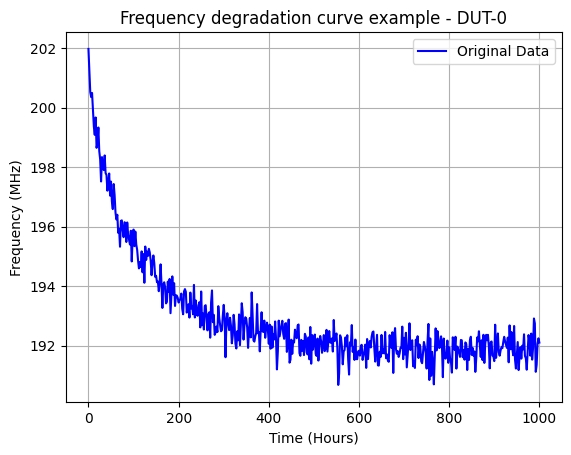

In [7]:
# General Variables
chip_no = 0      # Chip number to be displayed in the plot. Must be within `num_cols`

# Read in the data
x_data_plot = df_time
y_data_plot = df[df_cols[chip_no]]

# Plot the `chip_no` accelerated aging data
plt.plot(x_data_plot, y_data_plot, label='Original Data', color='blue')
plt.xlabel('Time (Hours)')
plt.ylabel(u'Frequency (MHz)')
plt.title(f'Frequency degradation curve example - DUT-{chip_no}')
plt.grid()
plt.legend()


The degradation data is normalized as required by the accelerated aging expression. Due to the inherent measuring noise in the data, a rolling average technique is used to filter this component.

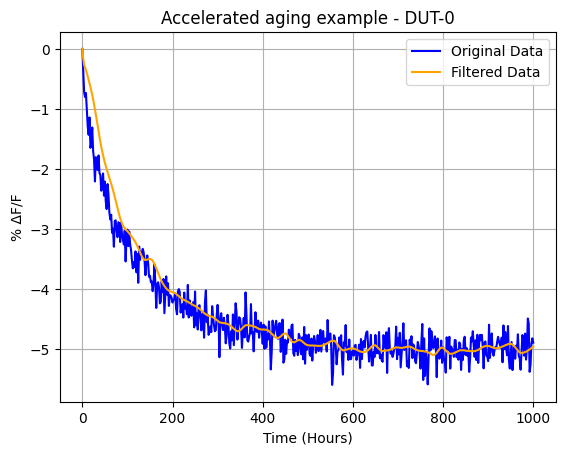

In [8]:
# Read in the data
x_data = np.array(df_time)
s_orig = 100*(y_data_plot - y_data_plot[0]) / y_data_plot[0]
s_aver = s_orig.rolling(window=20, center=False, win_type='hamming', min_periods=1).mean()
y_orig = np.array(s_orig)
y_aver = np.array(s_aver)

# Plot the `chip_no` accelerated aging data
plt.plot(x_data, y_orig, label='Original Data', color='blue')
plt.plot(x_data, y_aver, label='Filtered Data', color='orange')
plt.xlabel('Time (Hours)')
plt.ylabel(u'% ΔF/F')
plt.title(f'Accelerated aging example - DUT-{chip_no}')
plt.grid()
plt.legend()

## 2.0 Application of the model to the full degradation data

The following cell applies the model to the full degradation data series of `chip_no`. Some initial conditions and methods (`p0`, `bounds`, `method`) are set following the physical meanings of the variables mentioned at the beginning of the demo. The mean average error (**MAE**) is calculated to demonstrate the efficiency of the methodology.

Note that even though the complete array of data is being applied to the model, the MAE is non-zero. This effect is due to the high-frequency noise as the MAE is reduced after filtering it.

Text(0.5, 1.0, "Model applied to DUT-0's filtered data - MAE: 1.89%")

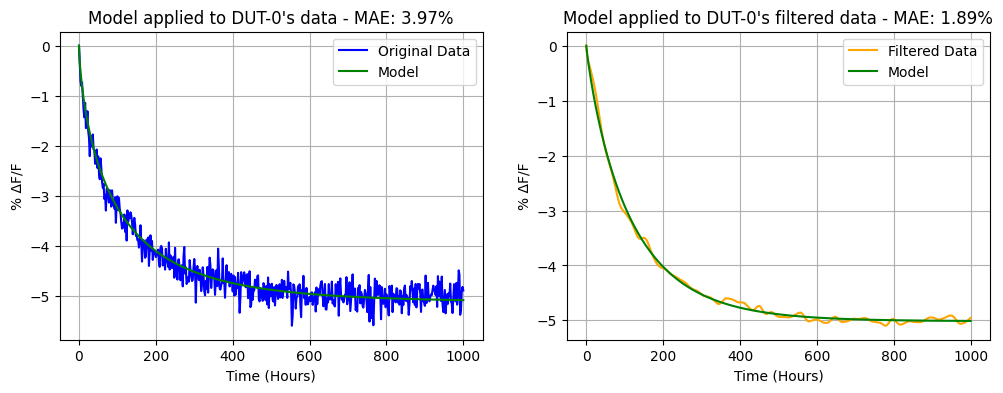

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# General Variables
p0 = None                                 # Initial guess for the Bernstein model parameters
bounds = ([-100, 1e-5, 0], [0, 1e-2, 1])  # Bounds for the fitting variables
methods = ['trf', 'dogbox', 'lm']         # Available methods for optimization
method = methods[1]

# Obtaining the model and applying the fitting variables
popt_orig, _ = curve_fit(bernstein_model, x_data, y_orig, bounds=bounds, method=method, p0=p0)
A_orig, B_orig, C_orig = popt_orig
model_orig = bernstein_model(x_data, A_orig, B_orig, C_orig)

popt, _ = curve_fit(bernstein_model, x_data, y_aver, bounds=bounds, method=method, p0=p0)
A, B, C = popt
model_aver = bernstein_model(x_data, A, B, C)

# Calculating the Mean Average Error (MAE)
mean_error_orig = np.mean(abs((model_orig[1:] - y_orig[1:]) / y_orig[1:]))*100
mean_error_aver = np.mean(abs((model_aver[1:] - y_aver[1:]) / y_aver[1:]))*100

# Plotting the data
ax1.plot(x_data, y_orig, label='Original Data', color='blue')
ax1.plot(x_data, model_orig, label='Model', color='green')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel(u'% ΔF/F')
ax1.set_title(f'Model applied to DUT-{chip_no}\'s data - MAE: {round(mean_error_orig,2)}%')

ax2.plot(x_data, y_aver, label='Filtered Data', color='orange')
ax2.plot(x_data, model_aver, label='Model', color='green')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Time (Hours)')
ax2.set_ylabel(u'% ΔF/F')
ax2.set_title(f'Model applied to DUT-{chip_no}\'s filtered data - MAE: {round(mean_error_aver,2)}%')

## 3.0 Forecasting degradation error using the model

The following cell only applies the first `obs` hours of degradation data to the model and then forecasts the remaining `test_length - obs` hours. This allows the user to only conduct the first `obs` hours of an experiment and then forecast the remaining degradation. The MAE reported only takes into account the predicted data (after the `obs` horizon) and is named predicted MAE (**PMAE**).

Text(0.5, 1.0, "Model applied to the first 500 hours of DUT-0's filtered data - PMAE: 2.51%")

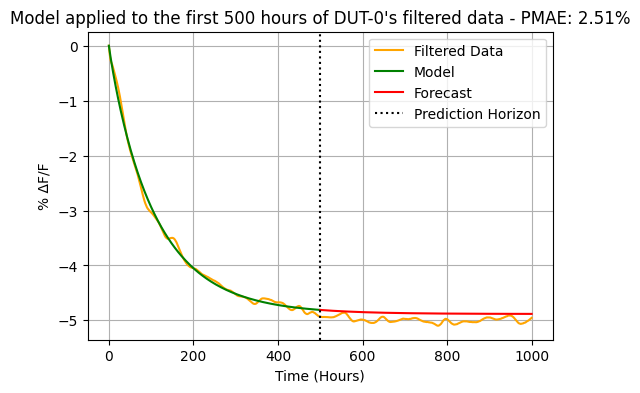

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

# General Variables
obs = 500     # Number of observed degradation hours given to the model. The hours predicted will be test_length-obs
pred_hor = int(obs*datapoints_per_hour)

# Obtaining the model and applying the fitting variables
popt, _ = curve_fit(bernstein_model, x_data[0:pred_hor], y_aver[0:pred_hor], bounds=bounds, method=method, p0=p0)
A, B, C = popt
model = bernstein_model(x_data, A, B, C)

# Calculating the Mean Average Error (MAE) and Prediction Mean Average Error (PMAE)
error = abs((model[1:] - y_aver[1:]) / y_aver[1:])
mean_error = np.mean(error)*100
error_prediction = abs((model[pred_hor:] - y_aver[pred_hor:]) / y_aver[pred_hor:])
mean_error_prediction = np.mean(error_prediction)*100

# Plotting the data
ax1.plot(x_data, y_aver, label='Filtered Data', color='orange')
ax1.plot(x_data[0:pred_hor], model[0:pred_hor], label='Model', color='green')
ax1.plot(x_data[pred_hor:], model[pred_hor:], label='Forecast', color='red')
ax1.axvline(x = obs, color = 'black', label = 'Prediction Horizon', linestyle=':')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel(u'% ΔF/F')
ax1.set_title(f'Model applied to the first {obs} hours of DUT-{chip_no}\'s filtered data - PMAE: {round(mean_error_prediction,2)}%')

### 3.1 Effect of the averaging window length in forecasting

The effect of the window length, `window` in the rolling average process is displayed in the following cell. As observed, a larger value of `window` implies that the filtered data becomes smoother. This can help the model fit better and the PMAE value reduce; however, increasing the `window` value too much might linearize the curve at a point where it loses its exponential characteristics.

Text(0.5, 1.0, 'Averaging with window length of 100 - PMAE: 6.22%')

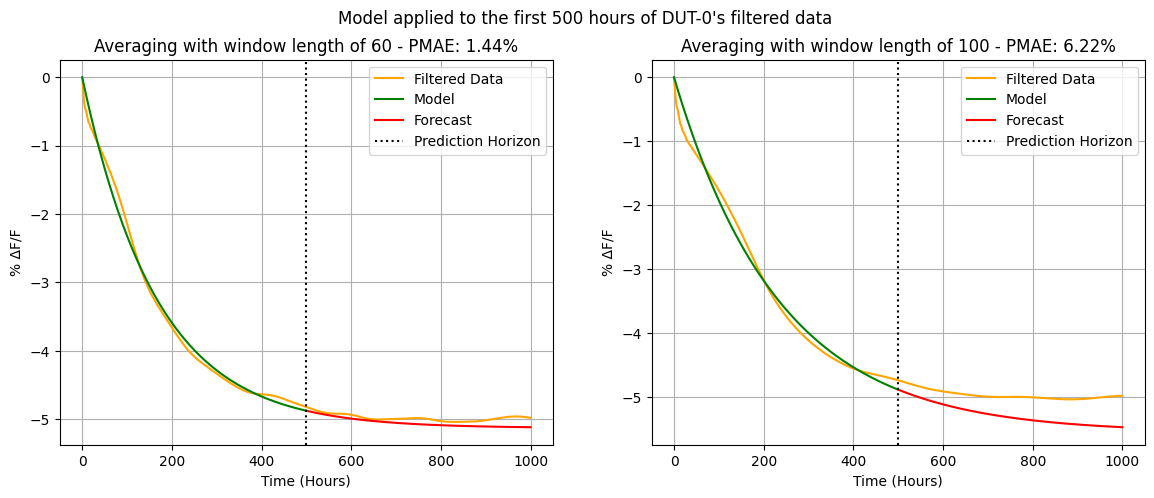

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# General Variables
obs = 500                                 # Number of observed degradation hours given to the model.
pred_hor = int(obs*datapoints_per_hour)
window1 = 60                              # Window length in rolling average
window2 = 100

# Read in data
y_aver1 = np.array(s_orig.rolling(window=window1, center=False, win_type='hamming', min_periods=1).mean())
y_aver2 = np.array(s_orig.rolling(window=window2, center=False, win_type='hamming', min_periods=1).mean())

# Obtaining the model and applying the fitting variables
popt, _ = curve_fit(bernstein_model, x_data[0:pred_hor], y_aver1[0:pred_hor], bounds=bounds, method=method, p0=p0)
A, B, C = popt
model1 = bernstein_model(x_data, A, B, C)

popt, _ = curve_fit(bernstein_model, x_data[0:pred_hor], y_aver2[0:pred_hor], bounds=bounds, method=method, p0=p0)
A, B, C = popt
model2 = bernstein_model(x_data, A, B, C)

# Calculating the Prediction Mean Average Error (PMAE)
error_prediction1 = abs((model1[pred_hor:] - y_aver1[pred_hor:]) / y_aver1[pred_hor:])
mean_error_prediction1 = np.mean(error_prediction1)*100

error_prediction2 = abs((model2[pred_hor:] - y_aver2[pred_hor:]) / y_aver2[pred_hor:])
mean_error_prediction2 = np.mean(error_prediction2)*100

# Plotting the data
ax1.plot(x_data, y_aver1, label='Filtered Data', color='orange')
ax1.plot(x_data[0:pred_hor], model1[0:pred_hor], label='Model', color='green')
ax1.plot(x_data[pred_hor:], model1[pred_hor:], label='Forecast', color='red')
ax1.axvline(x = obs, color = 'black', label = 'Prediction Horizon', linestyle=':')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel(u'% ΔF/F')
ax1.set_title(f'Averaging with window length of {window1} - PMAE: {round(mean_error_prediction1, 2)}%')
fig.suptitle(f'Model applied to the first {obs} hours of DUT-{chip_no}\'s filtered data\n')

ax2.plot(x_data, y_aver2, label='Filtered Data', color='orange')
ax2.plot(x_data[0:pred_hor], model2[0:pred_hor], label='Model', color='green')
ax2.plot(x_data[pred_hor:], model2[pred_hor:], label='Forecast', color='red')
ax2.axvline(x = obs, color = 'black', label = 'Prediction Horizon', linestyle=':')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Time (Hours)')
ax2.set_ylabel(u'% ΔF/F')
ax2.set_title(f'Averaging with window length of {window2} - PMAE: {round(mean_error_prediction2, 2)}%')

### 3.2 Effect of skipping datapoints in forecasting

Another experiment is done by changing the number of datapoints applied to the model. In this cell, all datapoints from 0 to `lim1` hours are used for fitting while `num_skips` every `num_skips + 1` are skipped in between `lim1` and `lim2` hours. A large value of window is used in the example.

Text(0.5, 1.0, "Skipping 10 datapoints in DUT-0's filtered data - PMAE: 0.84%")

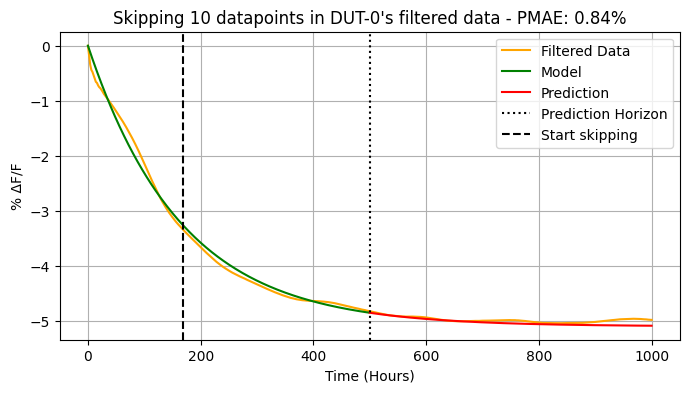

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))

# General Variables
num_skips = 10              # Number of points to be skipped
obs = 500                   # Number of observed hours
pred_hor = int(obs*datapoints_per_hour)
(lim1, lim2) = 168, obs     # Limits for skipping points
window = 60                 # Window length for smoothing

# Setting up the limits
DP_1 = int(lim1*datapoints_per_hour)
DP_2 = int(lim2*datapoints_per_hour)
DP_END = time_total

# From 0 to lim1 step of 1
# From lim1 to lim2 step of num_skips + 1
# From lim2 onwards step of 1 again
filter_list = list(range(0, int(DP_1), 1)) + \
              list(range(int(DP_1), int(DP_2), num_skips+1)) + \
              list(range(int(DP_2), int(DP_END)+1, 1))

# Read in the data
x_data = np.array(df_time)
s_orig = 100*(y_data_plot - y_data_plot[0]) / y_data_plot[0]
s_aver = s_orig.rolling(window=window, center=False, win_type='hamming', min_periods=1).mean()
y_orig = np.array(s_orig)
y_aver = np.array(s_aver)

s_skipped = s_aver.set_axis(x_data).filter(filter_list, axis=0)
x_skipped = np.array(s_skipped.index)
y_skipped = np.array(s_skipped)

# Apply the model
popt, pcov = curve_fit(bernstein_model, x_skipped[0:pred_hor], y_skipped[0:pred_hor], bounds=bounds, method=method, p0=p0)
A, B, C = popt
model = bernstein_model(x_data, A, B, C)

error_prediction = abs((model[pred_hor:] - y_aver[pred_hor:]) / y_aver[pred_hor:])
mean_error_prediction = np.mean(error_prediction)*100

# Plot the results
ax1.plot(x_data, y_aver, label='Filtered Data', color='orange')
ax1.plot(x_data[0:pred_hor], model[0:pred_hor], label='Model', color='green')
ax1.plot(x_data[pred_hor:], model[pred_hor:], label='Prediction', color='red')
ax1.axvline(x = obs, color = 'black', label = 'Prediction Horizon', linestyle=':')
ax1.axvline(x = lim1, color = 'black', label = 'Start skipping', linestyle='--')

ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel(u'% ΔF/F')
ax1.set_title(f'Skipping {num_skips} datapoints in DUT-{chip_no}\'s filtered data - PMAE: {round(mean_error_prediction, 2)}%')

## 4.0 Error summary

The following two cells iterate over an array of possible `obs` values and report the MAE and PMAE values. Note on the displayed dataframe that, as expected, by increasing the amount of `obs` hours, the error of the model decreases as it has more information to predict the rest of the series.

In [13]:
# General Variables
obs_list = list(range(200, int(time_total)+1, 25))  # Array of observed degradation hours
results_observations_df = pd.DataFrame(       # Dataframe to store the data
    {'DUT': [], 'ObsHrs': [], 'PMAE': []})
window = 60                                   # Window length for smoothing

# For every value in `obs_list`, apply the forecasting degradation
for obs in obs_list:

  pred_hor = int(obs*datapoints_per_hour)
  x_data = np.array(df_time)

  for chip_no in range(0, num_cols):
    y_data_plot = df[df_cols[chip_no]]
    s_orig = 100*(y_data_plot - y_data_plot[0]) / y_data_plot[0]
    s_aver = s_orig.rolling(window=window, center=False, win_type='hamming', min_periods=1).mean()
    y_orig = np.array(s_orig)
    y_aver = np.array(s_aver)

    try:
      popt, _ = curve_fit(bernstein_model, x_data[0:pred_hor], y_aver[0:pred_hor], bounds=bounds, method=method, p0=p0)
      A, B, C = popt
      model = bernstein_model(x_data, A, B, C)

      error_prediction = abs((model[pred_hor:] - y_aver[pred_hor:]) / y_aver[pred_hor:])
      mean_error_prediction = np.mean(error_prediction)*100

    except:
      print(f'Error encountered at OBS:{obs} Chip:{chip_no}')
      A, B, C, mean_error = np.nan, np.nan, np.nan, np.nan

    # Store the results on the dataframe
    aux_df = pd.DataFrame({'DUT': [chip_no], 'ObsHrs': [obs], 'PMAE': [mean_error_prediction]})
    results_observations_df = pd.concat([results_observations_df, aux_df], ignore_index=True, sort=False)


Error encountered at OBS:300 Chip:6


In [14]:
chip_no = 1  # Chip number to be displayed in the plot

# Dataframe with a summary of the MAE and PMAE values across observed hours
filtered_Results = results_observations_df[results_observations_df['DUT'] == chip_no]
filtered_Results[20:30]

,DUT,ObsHrs,PMAE
241,1.0,700.0,0.616122
253,1.0,725.0,0.256659
265,1.0,750.0,0.258714
277,1.0,775.0,0.237197
289,1.0,800.0,0.226886
301,1.0,825.0,0.251427
313,1.0,850.0,0.271769
325,1.0,875.0,0.241193
337,1.0,900.0,0.218938
349,1.0,925.0,0.259985


The following cell plots the PMAE of some DUTs as a function of the observed hours to indicate a diminishing returns behavior where, after around 400 hours, increasing the variable of `obs` does not decrease greatly the prediction error in this methodology

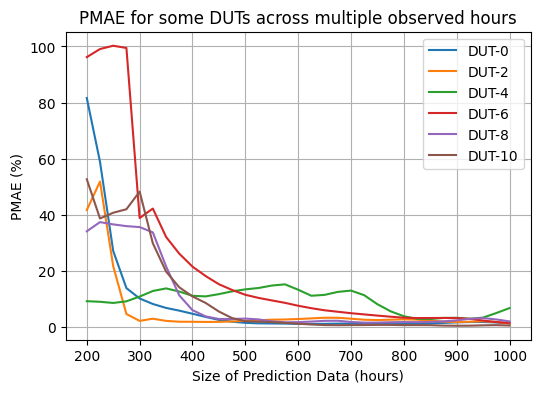

In [15]:
# Plotting the results
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

for chip_no in range(0, num_cols, 2):

  filtered_Results = results_observations_df[results_observations_df['DUT'] == chip_no]

  ax1.plot(np.array(filtered_Results['ObsHrs']), np.array(filtered_Results['PMAE']), label=f'DUT-{chip_no}')
ax1.set_xlabel('Size of Prediction Data (hours)')
ax1.set_ylabel('PMAE (%)')
ax1.set_title(f'PMAE for some DUTs across multiple observed hours')
ax1.grid()
ax1.legend()


## 5.0 Forecasting beyond recorded data

The following cell incorporates all of the data into the model and forecasts the degradation an additional `beyond` hours.

[0.000e+00 1.000e+00 2.000e+00 ... 1.498e+03 1.499e+03 1.500e+03]


Text(0.5, 1.0, "Forecasting 500 additional hours of DUT-3's accelerated aging data. Window length of 10 and skipped 0 points")

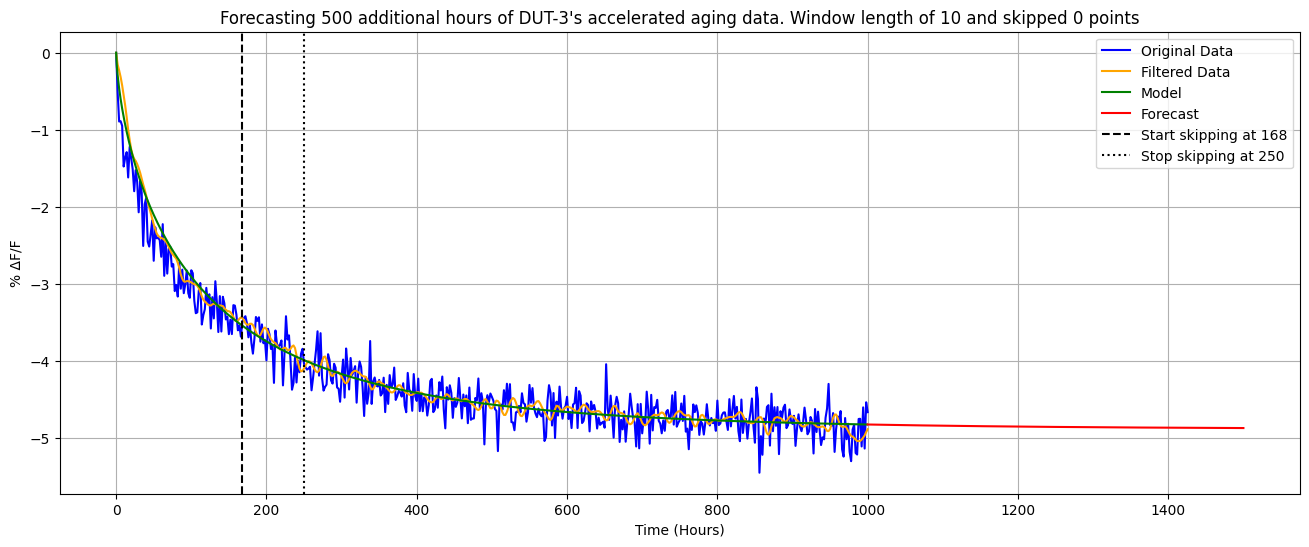

In [16]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))

# General Variables
chip_no = 3                 # Chip number to be displayed in the plot
num_skips = 0               # Number of points to be skipped
(lim1, lim2) = 168, 250     # Limits for skipping points
window = 10                 # Window length for smoothing
beyond = 500                # Number of additional hours to be predicted

DP_1 = int(lim1*datapoints_per_hour)
DP_2 = int(lim2*datapoints_per_hour)
DP_END = int(time_total)

filter_list = list(range(0, int(DP_1), 1)) + \
              list(range(int(DP_1), int(DP_2), num_skips+1)) + \
              list(range(int(DP_2), int(DP_END)+1, 1))

# Read in the data
y_data_plot = df[df_cols[chip_no]]
x_data = np.array(df_time)
x_beyond = np.linspace(0, DP_END + beyond, DP_END + beyond + 1)
s_orig = 100*(y_data_plot - y_data_plot[0]) / y_data_plot[0]
s_aver = s_orig.rolling(window=window, center=False, win_type='hamming', min_periods=1).mean()
y_orig = np.array(s_orig)
y_aver = np.array(s_aver)

s_skipped = s_aver.set_axis(x_data).filter(filter_list, axis=0)
x_skipped = np.array(s_skipped.index)
y_skipped = np.array(s_skipped)

# Apply the model
popt, pcov = curve_fit(bernstein_model, x_skipped[0:pred_hor], y_skipped[0:pred_hor], bounds=bounds, method=method, p0=p0)
A, B, C = popt
model = bernstein_model(x_beyond, A, B, C)

# Plot the results
ax1.plot(x_data, y_orig, label='Original Data', color='blue')
ax1.plot(x_data, y_aver, label='Filtered Data', color='orange')
print(x_beyond)
ax1.plot(x_beyond[0:DP_END], model[0:DP_END], label='Model', color='green')
ax1.plot(x_beyond[DP_END:], model[DP_END:], label='Forecast', color='red')
ax1.axvline(x = lim1, color = 'black', label = f'Start skipping at {lim1}', linestyle='--')
ax1.axvline(x = lim2, color = 'black', label = f'Stop skipping at {lim2}', linestyle=':')

ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel(u'% ΔF/F')
ax1.set_title(f'Forecasting {beyond} additional hours of DUT-{chip_no}\'s accelerated aging data. Window length of {window} and skipped {num_skips} points')

## 6.0 Extra section: a second order model for up- and down-jumps

A modification of the previous flow is presented in the following section. A second order model is implemented which uses the first derivative of the data to identify up- and down-jumps. In order to achieve this, the first derivate of the series is calculated. Then, the maximum value of the derivate is found as it contains information on the location of the jump as well as the type of jump. After the jump is found, the original series is divided in two segments to better fit and forecast the series.

The capabilities implemented allow the user to automatically identify a jump and whether it is an up- or down-jump. An additional dataset named `ExampleData_UpDownJumps.csv`. Thess change increase the complexity of the model but allows a reduction in the fitting errors.

### 6.1 Background

The following cell reads the default dataset `ExampleData_UpDownJumps.csv` or accepts a `.csv` with the constrains specified in section 0.0

In [17]:
df = pd.read_csv(f'./ExampleData_UpDownJumps.csv', index_col=0)
df

,Time (Hours),DUT_0,DUT_1,DUT_2,DUT_3,DUT_4,DUT_5,DUT_6,DUT_7,DUT_8,DUT_9,DUT_10,DUT_11
0,0.0,198.296168,203.572078,197.819931,198.971320,203.097921,203.432468,196.668234,204.413456,195.085914,200.045361,201.486627,202.954498
1,2.0,198.144762,203.392265,197.376560,198.247778,203.085726,203.233368,196.279719,204.359032,194.773412,200.000911,200.931467,202.629588
2,4.0,198.006045,203.134169,197.113804,197.871325,202.964917,203.035591,196.012536,204.544592,194.608636,200.086984,200.662083,202.432272
3,6.0,198.001174,203.088796,196.973172,197.808672,203.014396,202.693353,195.783358,204.398065,194.327470,199.912150,200.490278,202.346935
4,8.0,197.923113,202.927093,196.952965,197.642034,202.852599,202.592657,195.565620,204.401236,194.329605,200.013930,200.371755,202.303260
...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,992.0,192.047082,199.004693,191.587695,192.192289,201.850665,194.722258,189.046926,203.080775,189.608225,196.710774,195.450429,198.303252
497,994.0,191.984225,198.975128,191.610859,192.219596,201.809948,194.788897,189.050836,203.104037,189.611213,196.642406,195.454383,198.249558
498,996.0,191.978684,199.020216,191.668137,192.226954,201.685747,194.677297,188.997251,203.049769,189.575652,196.768910,195.328626,198.273839
499,998.0,191.989605,199.010617,191.650178,192.266372,201.814801,194.678615,188.979098,203.069114,189.591600,196.843830,195.489259,198.219480


Additionally, the following cell can also be used to generate a `.csv` file by randomly placing jumps. The variable `jump_hours` automatically produces a jump betwee the `50` and `225` hours. Random noise is also added. The new file will be exported if the `generate` variable is set to `True`.

In [18]:
# General Variables

num_chips = 12
vector_size = 501
test_length = 1000
generate = False

if generate:

  chip_list = list(range(0, num_chips))
  x_data = np.linspace(0, test_length, vector_size)
  df = pd.DataFrame({})
  df['Time (Hours)'] = x_data

  for chip in chip_list:

    A = random.uniform(-10, -1)
    B = random.uniform(1e-3, 1e-2)
    C = random.uniform(0.5, 0.9)
    Freq_0 = random.uniform(195, 205)
    jump_hours = int(random.uniform(50, 225))

    jump_norm = list(np.zeros(jump_hours*vector_size//test_length)) + list(np.ones(vector_size - jump_hours*vector_size//test_length))
    jump_data = random.uniform(-1.5, 1.5)*np.array(jump_norm)

    y_data = bernstein_model(x_data, A, B, C) + Freq_0
    y_noisy = y_data + np.random.normal(0, 0.05, size=vector_size)
    y_jump = y_noisy + jump_data

    df[f'DUT_{chip}'] = y_jump

  df.to_csv('./ExampleData_UpDownJumps.csv')

A summary of the dataset loaded is provided next.

In [19]:
df_time = list(df[list(df.columns)[0]])
time_total = df_time[-1]
df_cols = list(df.columns[1:])
num_cols = len(df.columns[1:])
num_datapoints = len(df)
datapoints_per_hour = 1/(df_time[1] - df_time[0])

print('DATASET INFORMATION SUMMARY:\n')
print(f'\tDUTs available: {df_cols}')
print(f'\tTotal number of DUTs: {num_cols}')
print(f'\tTotal number of datapoints: {num_datapoints}')
print(f'\tTotal number of hours recorded: {time_total}')
print(f'\tDatapoints collected per hour: {datapoints_per_hour}')

DATASET INFORMATION SUMMARY:

	DUTs available: ['DUT_0', 'DUT_1', 'DUT_2', 'DUT_3', 'DUT_4', 'DUT_5', 'DUT_6', 'DUT_7', 'DUT_8', 'DUT_9', 'DUT_10', 'DUT_11']
	Total number of DUTs: 12
	Total number of datapoints: 501
	Total number of hours recorded: 1000.0
	Datapoints collected per hour: 0.5


The following cell plots the degradation curve of the DUT with identifier `chip_no` with a default value of `4`. This DUT will also be subsequently analyzed through the application of the second order model.

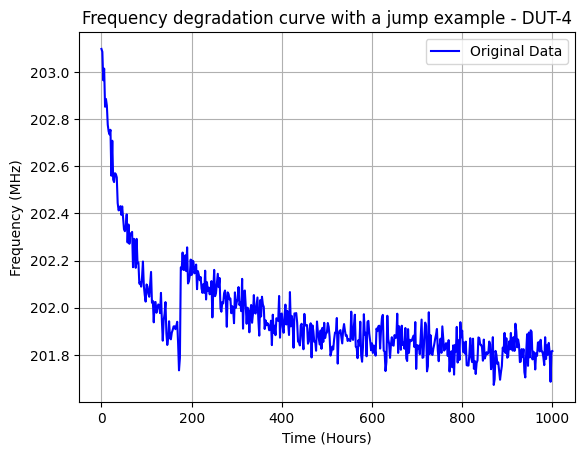

In [20]:
# General Variables
chip_no = 4         # DUT identifier

# Read in the data
x_data_plot = df_time
y_data_plot = df[df_cols[chip_no]]

# Plot the `chip_no` accelerated aging data
plt.plot(x_data_plot, y_data_plot, label='Original Data', color='blue')
plt.xlabel('Time (Hours)')
plt.ylabel(u'Frequency (MHz)')
plt.title(f'Frequency degradation curve with a jump example - DUT-{chip_no}')
plt.grid()
plt.legend()

### 6.2 Code implementation

The second order methodology is implemented in the following cell. The main new variables that the user can modify are `n` which sets the width of the window to calculate the local minima and maxima used in this process. The default value is `8`. An increase in this variable causes the amount of local minima and maxima found to decrease. Once the jump is identified through the derivative, the segments are broken down `th_jump` to the left and to the right of this point. Increasing this variable excludes more datapoints around the jump from the two segments.

A plot is provided to compare this additional feature with the regular implementation. It is observed that the second order model fits better around the jump which is demonstrated quantitative through the `MAE` error figure of merit.

Text(0.5, 0.98, 'Implementation of a second order model to detect a jump of type Up in DUT-4')

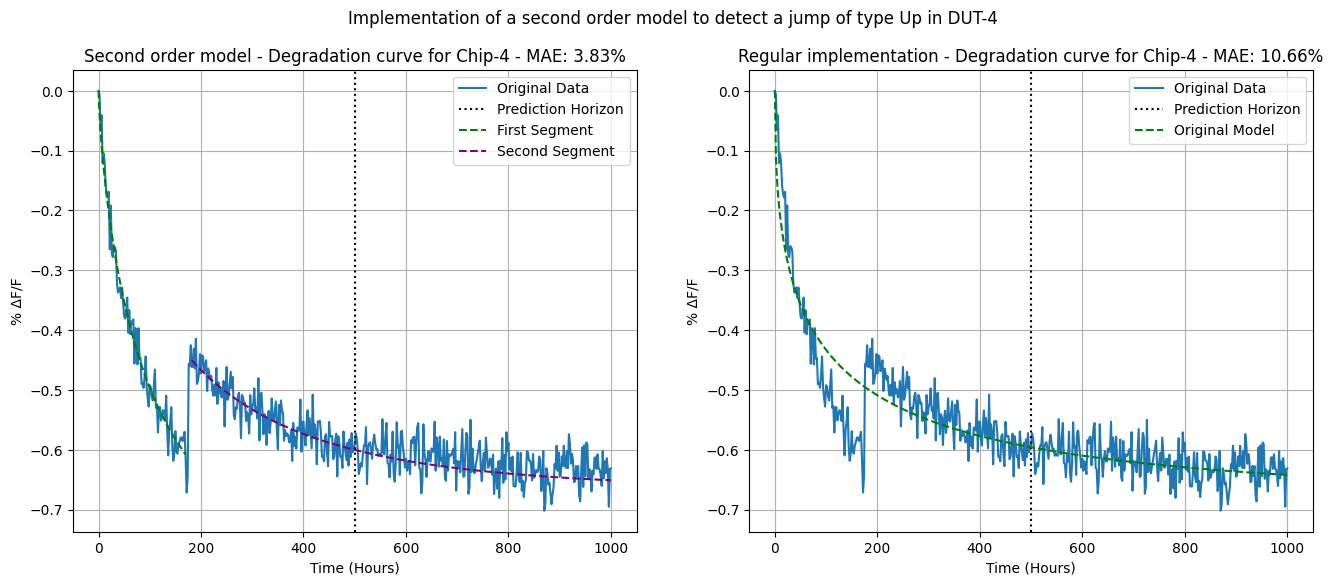

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# General Variables
n = 8           # Number of points used to find max and min
th_jump = 5     # Threshold break between segments
obs = 500       # Number of observed degradation hours

# Read in the data and obtain derivatives
x_data = np.array(df_time)
x_seri = pd.Series(x_data).set_axis(x_data)
s_orig = (100*(y_data_plot - y_data_plot[0]) / y_data_plot[0]).set_axis(x_data)
s_aver = s_orig.rolling(window=20, center=False, win_type='hamming', min_periods=1).mean()
y_orig = np.array(s_orig)
y_aver = np.array(s_aver)

Ser = s_orig.set_axis(x_data) # Data
Ser_Diff = Ser.diff()         # First derivative of the data

ax1.plot(x_seri, s_orig, label='Original Data')
ax1.axvline(x = obs, color = 'black', label = 'Prediction Horizon', linestyle=':')
ax2.plot(x_seri, s_orig, label='Original Data')
ax2.axvline(x = obs, color = 'black', label = 'Prediction Horizon', linestyle=':')

# Calculate the max and min from the first derivative
blu_FirMin = argrelextrema(np.array(Ser_Diff), np.less_equal, order=n)[0]//datapoints_per_hour
pur_FirMax = argrelextrema(np.array(Ser_Diff), np.greater_equal, order=n)[0]//datapoints_per_hour

# Find the value where the jump is occurring

max_val_der_blue = max(Ser_Diff[list(blu_FirMin)], key=abs)
ser_blue = Ser_Diff[list(blu_FirMin)]
idx_max_der_blue = ser_blue.index[pd.Index(ser_blue).get_loc(max_val_der_blue)]

max_val_der_purp = max(Ser_Diff[list(pur_FirMax)], key=abs)
ser_purp = Ser_Diff[list(pur_FirMax)]
idx_max_der_purp = ser_purp.index[pd.Index(ser_purp).get_loc(max_val_der_purp)]

jump_point = idx_max_der_blue if abs(max_val_der_blue) > abs(max_val_der_purp) else idx_max_der_purp
jump_type = 'Down' if abs(max_val_der_blue) > abs(max_val_der_purp) else 'Up'

# Calculate the segment before the jump
first_seg = int(jump_point - th_jump)
popt, pcov = curve_fit(bernstein_model, x_seri[0:first_seg], Ser[0:first_seg], bounds=bounds, method=method, p0=p0)
A, B, C = popt
model_first = bernstein_model(x_seri[0:first_seg], A, B, C)

ax1.plot(x_seri[0:first_seg], model_first, label='First Segment', linestyle="--", c='green')

# Calculate the  segment after the jump
sec_seg = int(jump_point + th_jump)

popt, pcov = curve_fit(bernstein_model, x_seri[sec_seg:obs], Ser[sec_seg:obs], bounds=bounds, method=method, p0=p0)
A, B, C = popt
model_sec = bernstein_model(x_seri[sec_seg:], A, B, C)

ax1.plot(x_seri[sec_seg:], model_sec[sec_seg:], label='Second Segment', linestyle="--", c='purple')

error_prediction_sec = abs((model_sec - Ser) / Ser)
mean_error_prediction_sec = np.mean(error_prediction_sec)*100

# Methodology for the previous implementation
popt, pcov = curve_fit(bernstein_model, x_seri, Ser, bounds=bounds, method=method, p0=p0)
A, B, C = popt
model_og = bernstein_model(x_seri, A, B, C)

error_prediction_og = abs((model_og - Ser) / Ser)
mean_error_prediction_og = np.mean(error_prediction_og)*100

ax2.plot(x_seri, model_og, label='Original Model', linestyle="--", c='green')

# Plot label and configurations
ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel(u'% ΔF/F')
ax1.set_title(f'Second order model - Degradation curve for Chip-{chip_no} - MAE: {round(mean_error_prediction_sec,2)}%')
ax2.grid()
ax2.set_xlabel('Time (Hours)')
ax2.set_ylabel(u'% ΔF/F')
ax2.set_title(f'Regular implementation - Degradation curve for Chip-{chip_no} - MAE: {round(mean_error_prediction_og,2)}%')
ax2.legend()
plt.suptitle(f'Implementation of a second order model to detect a jump of type {jump_type} in DUT-{chip_no}')

# Conclusions

The presented demo overviews the development of the acelerated aging forecasting methodology applied to an example dataset consisting of the degradation data of multiple DUTs. The model used is based on the Bernstein's equation for compact MOSFET wearout modeling. The error of the methodology is introduced through the prediction mean average error between the generated model and the actual degradation data. Fine-tuning through the averaging window length and possibility to skip some datapoints in the series can be done to decrease the error. The fifth section of this demo is then ready to be used for forecasting beyond the obtained experimental data once that all of the parameters of the model have been explained. Additionally, a second order model is presented expanding the regular flow of the methodology. By identifying possible up- and down-jumps in the data, the degradation curve can be broken down into two segments so that the model can fit around this jump. The implications of this second order model are visually represented in the demo and quantified through the mean average error.



# References

[1] P. Chanawala, “Methodology to Forecast a BTI-Induced Accelerated Aging Test Result”, MASc Thesis, University of British Columbia, 2022.

[2] X. Li, J. Qin and J. B. Bernstein, "Compact Modeling of MOSFET Wearout Mechanisms for Circuit-Reliability
Simulation," in IEEE Transactions on Device and Materials Reliability, vol. 8, no. 1, pp. 98-121, March 2008, doi:
10.1109/TDMR.2008.915629

[3] S. Zafar, “Statistical mechanics based model for negative bias temperature instability induced degradation,”
J. Appl. Phys., vol. 97, no. 1, pp. 1–9, 2005